In [1180]:
# Import Libraries
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Pre-processing
import kardiasclean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# KMeans Cluster
from sklearn.cluster import KMeans

## Part 1: Load Data

In [1181]:
# Load Data
path2 = Path("../database/clean2")
df = pd.read_csv(path2 / "db_patient.csv")
df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,date_birth,date_procedure,rachs,stay_days,expired
0,0,0,3942,35.0,134.0,0,2001-08-22,2012-04-08,1,2,0
1,1,1,3202,18.0,117.0,0,2003-09-19,2012-11-08,1,2,0
2,2,0,3147,22.0,120.0,0,2003-11-21,2012-08-18,1,2,0
3,3,0,4005,42.0,147.0,0,2001-10-07,2012-08-25,1,2,0
4,4,0,5289,40.0,157.0,0,1997-12-22,2012-01-09,1,3,0


In [1182]:
# Select feature columns for clustering
columns = [
    "patient_id",
    "gender",
    "age_days", 
    "weight_kg", 
    "height_cm", 
    "cx_previous",
    "rachs",
    "stay_days",
]
df = df[columns]
df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days
0,0,0,3942,35.0,134.0,0,1,2
1,1,1,3202,18.0,117.0,0,1,2
2,2,0,3147,22.0,120.0,0,1,2
3,3,0,4005,42.0,147.0,0,1,2
4,4,0,5289,40.0,157.0,0,1,3


In [1183]:
# Load additional columns: Diagnosis
diagnosis_df = pd.read_csv("../database/clean3/main_diagnosis_categories.csv")
diagnosis_df = diagnosis_df.rename(columns={"categories":"category_diagnosis"})
diagnosis_df.dropna(inplace=True)
diagnosis_df.head()

,patient_id,diagnosis_main,category_diagnosis
0,0,Comunicacion interauricular secundum,CIA
1,1,Comunicacion interauricular secundum,CIA
2,2,Comunicacion interauricular secundum,CIA
3,3,Comunicacion interauricular secundum,CIA
4,4,Comunicacion interauricular secundum,CIA


In [1184]:
# Load additional columns: Procedures
procedure_df = pd.read_csv("../database/clean3/db_patient_surgical_procedure_category.csv")
procedure_df.dropna(inplace=True)
procedure_df.head()

,patient_id,surgical_procedure,category_procedure
0,0,Reparacion de CIA parche,Parche comunicacion interauricular CIA
1,1,Reparacion de CIA parche,Parche comunicacion interauricular CIA
2,2,Reparacion de CIA parche,Parche comunicacion interauricular CIA
3,3,Reparacion de CIA parche,Parche comunicacion interauricular CIA
4,4,Reparacion de CIA parche,Parche comunicacion interauricular CIA


## Part 2: Pre-Processing

In [1185]:
# Bin all Columns by Quantile (aim for top 10)
THRESHOLD = 0.975
low, high = kardiasclean.perform_frequency_split_quantile(diagnosis_df['category_diagnosis'], THRESHOLD)
print(kardiasclean.evaluate_distribution(high, low))

diagnosis_df["category_diagnosis"] = kardiasclean.perform_binning_quantile(diagnosis_df["category_diagnosis"], THRESHOLD, bin_name="Other_Diagnosis")
encoded_diagnosis_df = kardiasclean.perform_matrix_encoding(diagnosis_df["category_diagnosis"], diagnosis_df["patient_id"], append_name=False)
print(encoded_diagnosis_df.shape)
encoded_diagnosis_df.head()

Total data (repeated): 1997
--------------------
Unique high frequency data: 9
Unique low frequency data: 336
--------------------
Total high frequency data: 1331
Total low frequency data: 666
--------------------
Percentage of high data: 66.65%
Percentage of low data: 33.35%
--------------------
Summary
--------------------
From 1997 data, 9 account for 66.65% of the total count.

(1003, 11)


,patient_id,CIA,CIV,Estenosis,PCA,Other_Diagnosis,Coartacion Aortica,Tetralogia de Fallot,Atresia,Post-Surgical Procedure,Hipoplasia
0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,0
4,4,1,0,0,0,0,0,0,0,0,0


In [1186]:
# Bin all Values by scalar (aim for Top 10)
THRESHOLD = 40
OTHER_NAME = "Other_Procedure"
procedure_df["category_procedure"] = procedure_df["category_procedure"].str.replace("Other", OTHER_NAME)
procedure_df["category_procedure"] = kardiasclean.perform_binning_scalar(procedure_df["category_procedure"], THRESHOLD, bin_name=OTHER_NAME)
encoded_procedure_df = kardiasclean.perform_matrix_encoding(procedure_df["category_procedure"], procedure_df["patient_id"], append_name=False)
print(encoded_procedure_df.shape)
encoded_procedure_df.head()

(1003, 11)


,patient_id,Parche comunicacion interauricular CIA,Vena cava inferior parche,Other_Procedure,Cierre de Conducto Arterioso,Reparacion de Canal AV,Reparacion de Tetralogia de Fallot,Procedimiento de Glenn,Reparacion de arco aortico,Fistula sistemico pulmonar,Procedimiento de Fontan
0,0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,0
4,4,1,0,0,0,0,0,0,0,0,0


In [1187]:
# Merge Patient Data with Diagnosis Data
merged_df = pd.merge(df, encoded_diagnosis_df, on="patient_id")
print(merged_df.shape)
merged_df.head()

(1003, 18)


,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days,CIA,CIV,Estenosis,PCA,Other_Diagnosis,Coartacion Aortica,Tetralogia de Fallot,Atresia,Post-Surgical Procedure,Hipoplasia
0,0,0,3942,35.0,134.0,0,1,2,1,0,0,0,0,0,0,0,0,0
1,1,1,3202,18.0,117.0,0,1,2,1,0,0,0,0,0,0,0,0,0
2,2,0,3147,22.0,120.0,0,1,2,1,0,0,0,0,0,0,0,0,0
3,3,0,4005,42.0,147.0,0,1,2,1,0,0,0,0,0,0,0,0,0
4,4,0,5289,40.0,157.0,0,1,3,1,0,0,0,0,0,0,0,0,0


In [1188]:
# Merge Patient and Diagnosis Data with Surgical Procedure Data
merged_df = pd.merge(merged_df, encoded_procedure_df, on="patient_id")
print(merged_df.shape)
print(merged_df.columns)
merged_df.head()

(1003, 28)
Index(['patient_id', 'gender', 'age_days', 'weight_kg', 'height_cm',
       'cx_previous', 'rachs', 'stay_days', 'CIA', 'CIV', 'Estenosis', 'PCA',
       'Other_Diagnosis', 'Coartacion Aortica', 'Tetralogia de Fallot',
       'Atresia', 'Post-Surgical Procedure', 'Hipoplasia',
       'Parche comunicacion interauricular CIA', 'Vena cava inferior parche',
       'Other_Procedure', 'Cierre de Conducto Arterioso',
       'Reparacion de Canal AV', 'Reparacion de Tetralogia de Fallot',
       'Procedimiento de Glenn', 'Reparacion de arco aortico',
       'Fistula sistemico pulmonar', 'Procedimiento de Fontan'],
      dtype='object')


,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days,CIA,CIV,...,Parche comunicacion interauricular CIA,Vena cava inferior parche,Other_Procedure,Cierre de Conducto Arterioso,Reparacion de Canal AV,Reparacion de Tetralogia de Fallot,Procedimiento de Glenn,Reparacion de arco aortico,Fistula sistemico pulmonar,Procedimiento de Fontan
0,0,0,3942,35.0,134.0,0,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
1,1,1,3202,18.0,117.0,0,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
2,2,0,3147,22.0,120.0,0,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
3,3,0,4005,42.0,147.0,0,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
4,4,0,5289,40.0,157.0,0,1,3,1,0,...,1,0,0,0,0,0,0,0,0,0


## Part 3: Principal Component Analysis

In [1189]:
y = merged_df["stay_days"]
X = merged_df.drop(columns=["stay_days", "patient_id"])
X_scaled = StandardScaler().fit_transform(X)
X_scaled.shape

(1003, 26)

0.9594443356615352

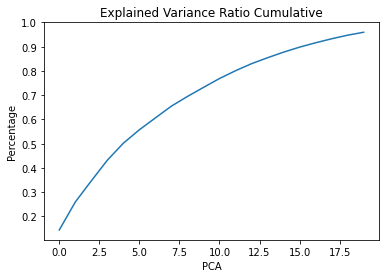

In [1190]:
# Evaluate PCA
def get_explained_variance_ratio(df: pd.DataFrame, n_components: int):
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(df)
    return data, np.asarray(pca.explained_variance_ratio_)

N_COMPONENTS = 20
data, evr = get_explained_variance_ratio(X_scaled, N_COMPONENTS)
X_pca = pd.DataFrame(data, columns=[f"PC{x+1}" for x in range(N_COMPONENTS)])

plt.plot(np.cumsum(evr))
plt.title("Explained Variance Ratio Cumulative")
plt.xlabel("PCA")
plt.ylabel("Percentage")
sum(evr)

## Part 4: KMeans

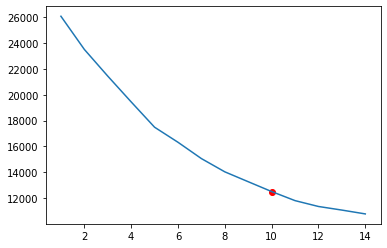

In [1191]:
# Plot the Elbow curve
RANDOM_STATE = 100
sse = pd.Series({k: KMeans(n_clusters=k, random_state=RANDOM_STATE).fit(X_scaled).inertia_ for k in range(1, 15)})
N_CLUSTERS = 10
plt.scatter(N_CLUSTERS, sse[N_CLUSTERS], color="red")
plt.plot(sse.index, sse.values)

In [1192]:
# Create Clusters
model = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE).fit(X_scaled)
clusters = pd.Series(model.predict(X_scaled))
print("Patients per Cluster")
clusters.value_counts().sort_index()

Patients per Cluster


0     41
1    151
2     59
3    155
4     52
5    302
6     91
7     57
8     55
9     40
dtype: int64

In [1193]:
# Store Model
import pickle

path = Path("./models")
with open(path / f"kmeans_{N_CLUSTERS}.pkl", "wb") as f:
    pickle.dump(model, f)

with open(path / f"kmeans_{N_CLUSTERS}.pkl", "rb") as f:
    model = pickle.load(f)

print(model.predict(X_scaled[100].reshape(1, -1)))
X_scaled[100].reshape(1, -1)

[5]


array([[ 1.00700359, -0.78277451, -0.74823937, -0.96171189, -0.36179787,
        -0.17446073, -0.56701297, -0.66794165, -0.33560199, -0.55633724,
         0.32145456, -0.28016892, -0.33277916, -0.25849096, -0.2774101 ,
        -0.24407118, -0.4581391 , -0.47402114,  0.17138782, -0.33462426,
        -0.20380595, -0.31396835, -0.25888468, -0.24317506, -0.21164042,
        -0.23854141]])

In [1194]:
# Merge with ORIGINAL DATA
clustered_df = merged_df.copy(deep=True)
clustered_df["cluster"] = clusters
clustered_df.head()

,patient_id,gender,age_days,weight_kg,height_cm,cx_previous,rachs,stay_days,CIA,CIV,...,Vena cava inferior parche,Other_Procedure,Cierre de Conducto Arterioso,Reparacion de Canal AV,Reparacion de Tetralogia de Fallot,Procedimiento de Glenn,Reparacion de arco aortico,Fistula sistemico pulmonar,Procedimiento de Fontan,cluster
0,0,0,3942,35.0,134.0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,3202,18.0,117.0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,1
2,2,0,3147,22.0,120.0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,1
3,3,0,4005,42.0,147.0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,0,1
4,4,0,5289,40.0,157.0,0,1,3,1,0,...,0,0,0,0,0,0,0,0,0,1


Text(0, 0.5, 'Average Stay Days')

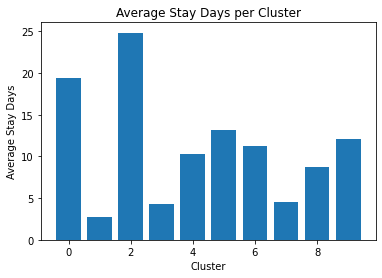

In [1195]:
# Look at clusters
plot_data = clustered_df.groupby("cluster").mean()["stay_days"]
plot_x = plot_data.index
plot_y = plot_data.values
plt.bar(plot_x, plot_y)
plt.title("Average Stay Days per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Stay Days")

In [1196]:
# Create a Table of mean values per cluster
cluster_mean_df = pd.DataFrame()
target_names = ["stay_days", "rachs", "cx_previous", "age_days"]

# Process each cluster's data
for i in range(N_CLUSTERS):
    c_df = clustered_df[clustered_df["cluster"] == i]
    targets = [c_df[t].mean() for t in target_names]
    # t2 = [c_df[t].std() for t in target_names]
    cluster_mean_df[f"{i+1}".zfill(2)] = [
        c_df.count()[0], 
        *targets, 
        # *t2
    ]

# Rename Index
cluster_mean_df.index = [
    "n_patients", 
    *target_names, 
    # *[f"std_{t}" for t in target_names]
]
# Transpose and Sort Data
sort_by = "stay_days"
cluster_mean_df = cluster_mean_df.transpose().sort_values(by=sort_by)
cluster_mean_df.index.name = "Cluster"
print("Table of Cluster x Mean Values")
# Div
cluster_mean_df

Table of Cluster x Mean Values


,n_patients,stay_days,rachs,cx_previous,age_days
Cluster,,,,,
02,151.0,2.682119,1.105960,0.019868,2419.304636
04,155.0,4.348387,2.032258,0.045161,1033.683871
08,57.0,4.543860,1.859649,0.192982,5079.017544
09,55.0,8.763636,2.290909,0.327273,866.472727
05,52.0,10.288462,2.865385,1.711538,2428.173077
07,91.0,11.263736,2.065934,0.076923,1052.956044
10,40.0,12.100000,2.775000,0.100000,720.225000
06,302.0,13.168874,2.149007,0.112583,885.493377
01,41.0,19.390244,2.902439,0.292683,346.731707


In [1197]:
# Outliers


Text(0.5, 1.0, 'Clusters Stay Days vs Rachs')

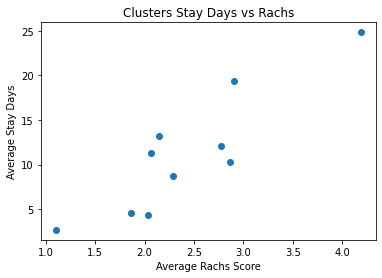

In [1198]:
# Visualize stay days and rachs by cluster
plt.scatter(cluster_mean_df['rachs'], cluster_mean_df['stay_days'])
plt.xlabel("Average Rachs Score")
plt.ylabel("Average Stay Days")
plt.title("Clusters Stay Days vs Rachs")

In [1199]:
# Format Results so they look better (They become strings)
formated_df = cluster_mean_df.applymap(lambda x: f"{x:.2f}")
formated_df.to_csv("../visualization/csv/clusters_full_stats.csv", index=False)
formated_df

,n_patients,stay_days,rachs,cx_previous,age_days
Cluster,,,,,
02,151.00,2.68,1.11,0.02,2419.30
04,155.00,4.35,2.03,0.05,1033.68
08,57.00,4.54,1.86,0.19,5079.02
09,55.00,8.76,2.29,0.33,866.47
05,52.00,10.29,2.87,1.71,2428.17
07,91.00,11.26,2.07,0.08,1052.96
10,40.00,12.10,2.77,0.10,720.23
06,302.00,13.17,2.15,0.11,885.49
01,41.00,19.39,2.90,0.29,346.73


## Part 5: Linear Regression

In [1200]:
# Select Feature and Target
X = cluster_mean_df["rachs"].values.reshape(-1, 1)
y = cluster_mean_df["stay_days"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X.shape, y.shape

((10, 1), (10, 1))

In [1201]:
# Train Model
model = LinearRegression()
model.fit(X_train, y_train)
model.coef_

array([[6.98565047]])

In [1202]:
# Predict and Evaluate Model
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
print("r-squared:", r2)
print("mean-squared error:", mse)
score = model.score(X_test, y_test)
print("accuracy:", score)

r-squared: 0.7806452229286882
mean-squared error: 9.390419849263834
accuracy: 0.934082149939249


Text(0, 0.5, 'Average Stay Days')

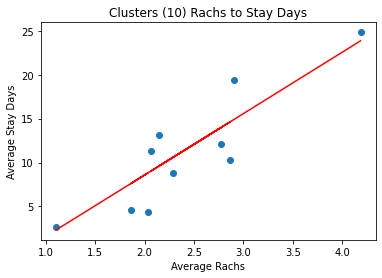

In [1203]:
# Visualize Linear Regression on Clusters
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.title(f"Clusters ({N_CLUSTERS}) Rachs to Stay Days")
plt.xlabel("Average Rachs")
plt.ylabel("Average Stay Days")